# Logistic Regression

## Standards/Objectives

 * Place logistic regression in the taxonomy of ML algorithms
 * Explain the key differences and similarities between logistic and linear regression.
 * Fit and interpret a logistic regression model in scikit-learn
 * Interpret the coefficients of logistic regression, using odds ratio

## Logistic regression as a model

Logistic regression is a supervised-learning parametric classification model. It's generally the first thing you try when building a classifier, and is actually used in some production environments.

Advantages:

 * Fast (for training and prediction)
 * Simple (few hyperparameters)
 * Interpretable
 * Provides probability
 
Disadvantages

 * Requires feature engineering to capture non-linear relationships
 * Doesn't work for p > n


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
import itertools

## Why not linear regression?

Let's suppose we have some (fake) data, but that $y$ (the target) is always either 0 or 1.

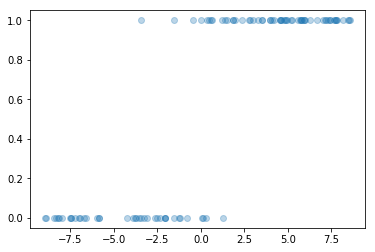

In [2]:
npts = 100

X = scs.uniform(-9, 18).rvs(npts).reshape(npts,1)
y = scs.bernoulli(scipy.special.expit(X[:,0])).rvs(npts)

fig, ax = plt.subplots()
ax.plot(X, y, 'o', alpha=0.3)

We just learned linear regression. Let's use that to predict $y$!

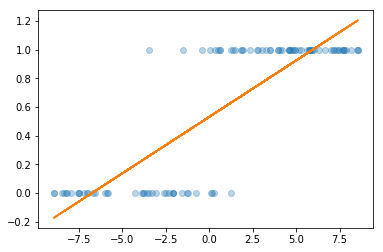

In [3]:
model = LinearRegression()
model.fit(X, y)
ax.plot(X, model.predict(X))
fig

Discussion: what's wrong with this?

## Comparison to linear regression

Recall that with linear regression we assume the data follows the form

$$\begin{align}
Y & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p + \epsilon \\
  & = \mathbf{X} \beta + \epsilon
\end{align}$$

where again

$$\epsilon \sim N(0, \sigma)$$

Alternatively, we could say
$$Y \sim N(\mathbf{X} \beta, \sigma)$$

From there, we want to find the values for $\beta$ that are the most likely to produce the data. The MLE estimate gives us ordinary least squares.

Question: what is MLE?

### Constructing a model

To do any sort of prediction we need to create a model. Since we have two possible values of $y$ we assume the data is the result of a Bernoulli distribution, where $p$ is a function of $\mathbf{X}$.

$$Y \sim Bernoulli(f(\mathbf{X}))$$

We want our model to include some parameters so, as with linear regression, we'll have the function depend on the product of those parameters and $\mathbf{X}$.

$$Y \sim Bernoulli(f(\mathbf{X} \beta))$$

or


$$Y \sim Bernoulli(f(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p)$$

For $f$ we want a function with values from 0 to 1, what's called a sigmoid function. There are a number of different choices, but (for reasons we'll talk about later), the usual choice is something called the logistic function.

$$f(x) = \frac{1}{1+e^{-x}}$$

Question: now that we have a model, how should we find the best fit?

(0, 1)

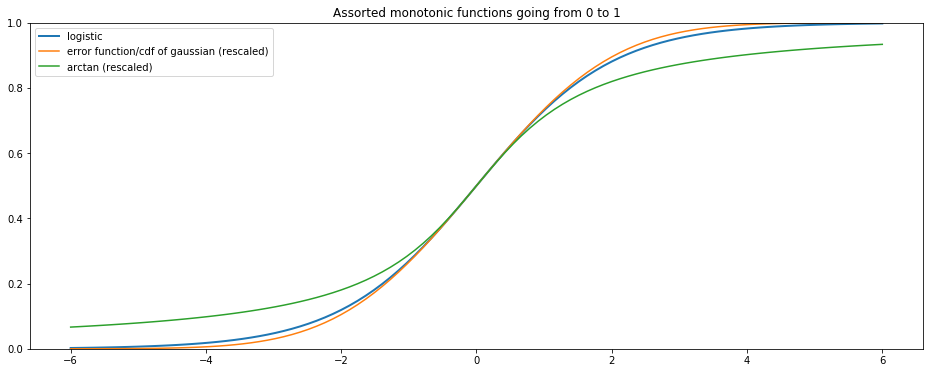

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
xpts = np.linspace(-6, 6, 100)
ax.plot(xpts, 1/(1+np.exp(-xpts)), label='logistic', lw=2)
ax.plot(xpts, scs.norm(0,1).cdf((2*np.pi)**.5/4 * xpts), label='error function/cdf of gaussian (rescaled)')
ax.plot(xpts, np.arctan(np.pi/4*xpts)/np.pi + 0.5, label='arctan (rescaled)')
ax.legend()
ax.set_title("Assorted monotonic functions going from 0 to 1")
ax.set_ylim(0, 1)

Again, we solve with maximum-likelihood estimation. Note that there isn't a close-form solution here; the computer has to solve numerically using some form of gradiant descent (we'll talk about this in the next few days).

## Example (with fake data)

We'll generate fake data that matches the distribution exactly and try to recover the parameters.

In [6]:
def logistic(x):
    return 1/(1 + np.exp(-x))

In [10]:
npts = 100
beta0 = 0.0
beta1 = 0.5

X = scs.uniform(-9, 18).rvs(npts).reshape(npts,1)
# the expit function is the same as the logistic function
y = scs.bernoulli(logistic(beta0 + beta1*X[:,0])).rvs(npts)

We graph the data; the vertical line shows the actual decision boundary where the probability is 0.5.

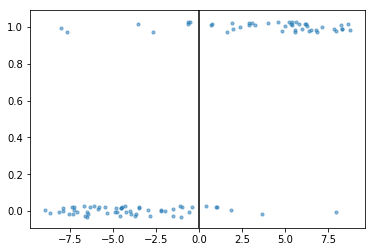

In [11]:
jitter = scs.uniform(-0.03,0.06).rvs(npts)
fig, ax = plt.subplots()
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5)
ax.axvline(-beta0/beta1, color='black')

In [12]:
# set C large to suppress regularization
model = LogisticRegression(C=1000)
model.fit(X, y)
beta0hat = model.intercept_[0]
beta1hat = model.coef_[0][0]
print("beta0 =    {0:8.3f} beta1 =    {1:8.3f}".format(beta0, beta1))
print("beta0hat = {0:8.3f} beta1hat = {1:8.3f}".format(beta0hat, beta1hat))

beta0 =       0.000 beta1 =       0.500
beta0hat =   -0.137 beta1hat =    0.453


/Users/natalie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's draw the curve we fitted on the data, along with the actual curve used to create the data.


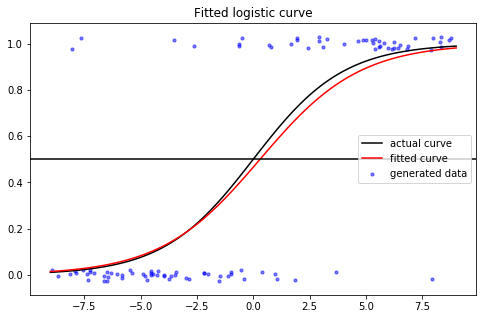

In [13]:
xpts = np.linspace(-9, 9, 100)
yhatpts = logistic(beta0hat + beta1hat * xpts)
ypts = logistic(beta0 + beta1 * xpts)

jitter = scs.uniform(-0.03,0.06).rvs(npts)

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5, color='blue', label="generated data")
ax.plot(xpts, ypts, 'k', label='actual curve')
ax.plot(xpts, yhatpts, 'r', label='fitted curve')
ax.axhline(0.5, color='black')
#ax.axvline(-beta0/beta1, color='black', label='actual boundary')
ax.set_title("Fitted logistic curve")
ax.legend(loc='center right')

## Log odds ratio

In gambling people often talk about **odds**. If the local sportsball is favored to win 3-to-1 (or 3:1), that means that the ratio of the probability of winning is three times as great as the probability of losing, so they have a 75% chance of winning. Odd of 1:1 are even; they are as likely to win as the are to lose.

(In gambling people always give the larger number first, so a 25% chance of winning is said to be 3:1 against. We won't do that.)

The **odds ratio** is the ratio of the of the probablity of the positive to the negative case, i.e., 

$$OR = \frac{P(y=1)}{1-P(y=1)}$$

Question: what's the odds ratio if $P(y=1) = 0.5$?

Question: what if the probability of the positive class is 80%?

Question: what if it's 20%?

Question: what if it's 10%?

The **log odds ratio** is just the log (base e) of that.

Question: what is the log odds ratio if $P(y=1) = 0.5$

Question: what if it's 80%?

Question: what if it's 20%?

So what does that have to do with logistic regression? The logistic function takes the log odds of something and returns the probability. Let's explore this a bit more.

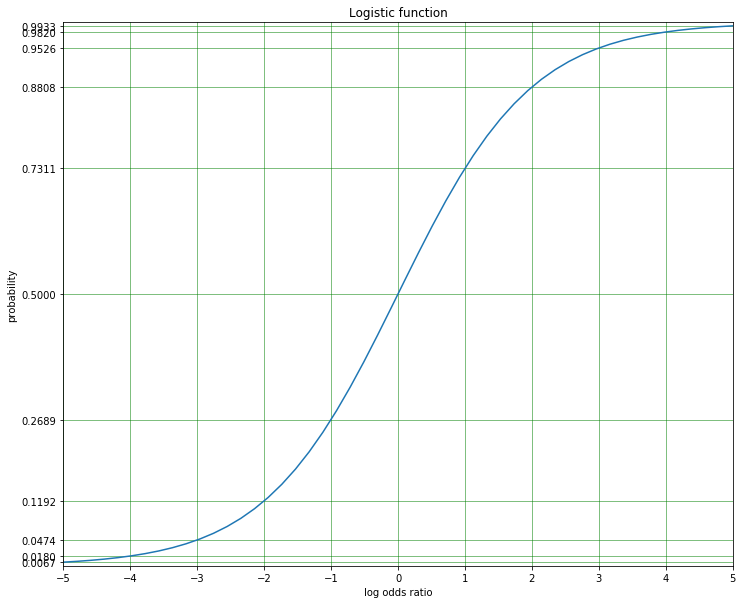

In [10]:
xpts = np.linspace(-5, 5)
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(xpts, logistic(xpts))

xticks = np.arange(-5, 6, 1)
ax.set_xticks(xticks)
ax.set_yticks(logistic(xticks))

ax.grid(color='g', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-0, 1)
ax.set_title("Logistic function")
ax.set_xlabel("log odds ratio")
ax.set_ylabel("probability")
plt.show()

In [11]:
x = np.arange(-10, 11)
df = pd.DataFrame(['{:.3f}%'.format(a*100) for a in logistic(x)], index=x, columns=['probability'])
df.index.name = 'log odds ratio'
df

,probability
log odds ratio,
-10,0.005%
-9,0.012%
-8,0.034%
-7,0.091%
-6,0.247%
-5,0.669%
-4,1.799%
-3,4.743%
-2,11.920%


### The math

If you're doing logistic regression, then the probability of something being in the positive class is
$$P(y=1) = \frac{1}{1+e^{-\mathbf{X}\beta}}$$

so

$$\begin{align}
OR &= \frac{P(y=1)}{1-P(y=1)} \\
   &= \frac{\frac{1}{1+e^{-\mathbf{X}\beta}}}{1-\frac{1}{1+e^{-\mathbf{X}\beta}}} \\
   &= \frac{\frac{1}{1+e^{-\mathbf{X}\beta}}}{\frac{1+e^{-\mathbf{X}\beta}}{1+e^{-\mathbf{X}\beta}}-\frac{1}{1+e^{-\mathbf{X}\beta}}} \\
   &= \frac{1}{e^{-\mathbf{X}\beta}} \\
   &= e^{\mathbf{X}\beta}
\end{align}
$$
so
$$log(OR) = \mathbf{X}\beta$$

So if you increase $X_i$ by 1, you increase $log(OR)$ by $\beta_i$.

## Decision boundary

Over the next couple weeks we'll talk about a number of different classification models. A good model will do more than just predict to which class something belongs; it will predict the probability that it is in that class.

At some point, though, we need to make a decision. To do that we choose a **threshold** at which we will place something in one class or the other. The **decision boundary** is the surface in feature space at which the probability is equal to the threshold.

Suppose we have two features, $X_1$ and $X_2$, and we set the threshold equal to 0.5. That corresponds to a log odds ratio of 0 so the decision boundary is at

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$$

so

$$ X_2 = \frac{-\beta_0}{\beta_2} + \frac{-\beta_1}{\beta_2}X_1 $$

More broadly, for threshold $\theta$, the decision boundary is the region for which

$$\theta = \frac{1}{1+e^{-\mathbf{X} \beta}}$$

$$\theta + \theta e^{-\mathbf{X} \beta} = 1$$

$$e^{-\mathbf{X} \beta} = \frac{1 - \theta}{\theta}$$

$$\mathbf{X} \beta = \ln{(\frac{\theta}{1 - \theta})}$$

Which again is the log odds ratio, so

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = \ln{(\frac{\theta}{1 - \theta})}$$

so

$$X_2 = \frac{\ln{(\frac{\theta}{1 - \theta})} - \beta_0}{\beta_2} +  \frac{-\beta_1}{\beta_2}X_1 $$

In [12]:
def generate_classes(nptses, mus, sds):
    """
    Generate normally distributed points in multiple classes
    Parameters
    ----------
    nptses : array_like (1-d)
        sequence of numbers, the count of points in each class
    mus : array_like (2-d)
        sequence of vectors, the means of the multivariate distributions for each class
    mus : array_like (3-d)
        sequence of 2-d symmetric tensors, the standard deviation of the multivariate
        distributions for each class
        
    Returns
    -------
    X : array (2-d)
        features of generated points
    y : array (2-d)
        integer labels of points, starting at 0
    """

    X = np.zeros((0,2))
    y = np.zeros((0,))
    
    for i, npts, mu, sd in zip(itertools.count(), nptses, mus, sds):
        X = np.concatenate([X, scs.multivariate_normal(mu, sd).rvs(npts)])
        y = np.concatenate([y, np.ones(npts)*i])
    return X, y
        

In [13]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )

In [14]:
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (np.log((1 - threshold)/threshold) - b0 - x*b1 )/b2

def plot_decision_boundary(X, y, model, ax=None):
    '''plot 2-d array of points, with decision boundaries'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=3)
    ax.plot(*X[y==0].mean(axis=0).reshape(-1,1), color='b', marker='+', mew=4, ms=20)
    ax.plot(*X[y==1].mean(axis=0).reshape(-1,1), color='g', marker='+', mew=4, ms=20)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    print (beta0, beta1, beta2)
    
    for threshold, ls in zip(1/(1+np.exp(-np.arange(-3,4))), [':', '-.', '--', '-', '--', '-.', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color='r',
                ls=ls,
                label="{:.2f}%".format(threshold*100))
    ax.legend(title='threshold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

(array([-6.06500273]), 1.7675503854732075, -0.67960498320045815)


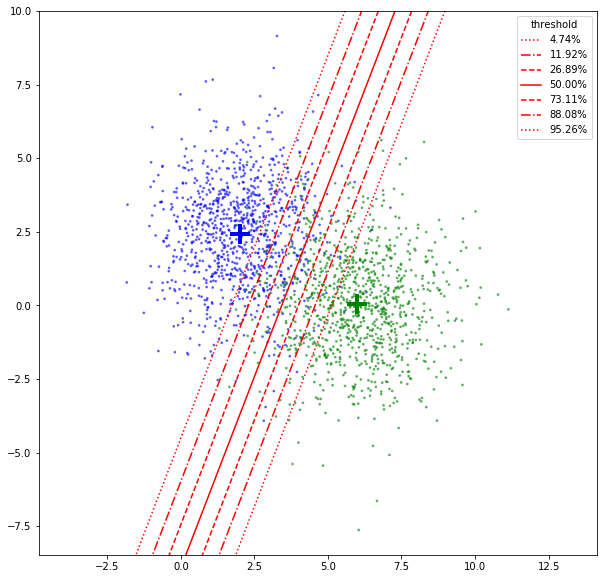

In [15]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )
model = LogisticRegression(C=1000, intercept_scaling=100)
model.fit(X, y)

plot_decision_boundary(X, y, model)

### (end of morning lecture)

### Finding the $\beta$ coefficients

We can use MLE if we construct a likelihood function.

We assume 
$$y \sim Bernoulli(h(\vec{x}\cdot \vec{\beta}))$$

For a Bernoulli trial with success probability $p$, the likelihood is
$$ P(y|p) = p^y(1-p)^{1-y} $$

So for our case, 

$$L(\vec{\beta}) = \prod_i h(\vec{\beta}\cdot \vec{x}_i)^{y_i}(1-h(\vec{\beta}\cdot \vec{x}_i))^{1-y_i}$$

Unfortunately, setting the derivative of the likelihood to zero results in a set of nonlinear equations for $\beta_j$ that has **no analytical solution**. Frowning emoticon.

Tomorrow we'll show how to numerically maximize the likelihood. For computational convenience, we often use the log likelihood. 

$$\log L(\vec{\beta}) = \sum_i \left(\, y_i\,\text{log}(h(\vec{\beta}\cdot \vec{x}_i)) + (1 - y_i)\log(1 - h(\vec{\beta}\cdot \vec{x}_i))\, \right)$$

Also, since in general we talk about minimizing a cost function, let's call the cost function $J$ for logistic regression the *negative log likelihood*, often called the "log loss".
$$ J(\vec{\beta}) = -\log L(\vec{\beta}) $$

For now, take it for granted that we can call `.fit()` and get out the values of the $\beta$ parameters that maximize the likelihood (and so minimize $J$)

### How do you score a soft classifier?

**[log loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)** is simply the negative log likelihood defined above

In [15]:
from sklearn.metrics import log_loss

To get the total log loss, specify `normalize=False`, otherwise you will get the average log loss per sample.

In [16]:
train_pred_probs = model.predict_proba(X)

In [17]:
log_loss(y, train_pred_probs, normalize=False)

35.253710707912525

In [18]:
log_loss(y, train_pred_probs)

0.3525371070791252

# Afternoon Lecture – Evaluating a Binary Classifier


## Confusion matrix

A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) gives the count of instances based on the actual and predicted values of the target. For a binary classifier it looks like

|          &#xfeff;           | Predicted positive | Predicted negative |
|---------------------|--------------------|--------------------|
| **Actual positive** |   true positive    |  false negative    | 
| **Actual negative** |   false positive   |  true negative     |


*True* and *false* refer to whether you are correct.

*Positive* and *negative* refer to the **predicted** result.

A *type-I error* is a false positive (which I remember because that phrase is more common than false negative).

Accuracy $= \frac{TP+TN}{TP+TN+FP+FN}$

Sensitivity = Recall = TPR $= \frac{TP}{TP+FN}$

FPR $= \frac{FP}{TN+FP}$

Specificity $= \frac{TN}{TN+FP}$

Precision = PPV $= \frac{TP}{TP+FP}$

NPV $= \frac{TN}{TN+FN}$

![confusion matrix](Confusion_Matrix.png)

#### F-score

$F_\beta$ evaluates a test assuming that recall is $\beta$ times as important as precision; it's a weighted harmonic mean of the two.

$$F_\beta = (1+\beta^2) \frac{\text{precision} \cdot \text{recall}}{\beta^2\text{precision} + \text{recall} } $$

$$F_1 = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall} }  = \frac{1}{\frac{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}}$$

## ROC Curves

Any decent classification model will provide the probabilities that a data point is in one class or another. To visualize the overally goodness of a model we use a Receiver Operator Characteristic curve, which shows the TPR (a.k.a Sensitivity) and FPR (a.k.a. 1-Specificity) for various thresholds.

An alternative is the Precision-recall curve, which is more appropriate when you're more interested in the positive class.

Models can be compared by the Area Under the Curve (AUC) of either graph.

In [20]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [21]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )
model = LogisticRegression(C=1000)
model.fit(X, y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

(array([-6.16461816]), 1.8393701509838862, -0.87481240383969006)


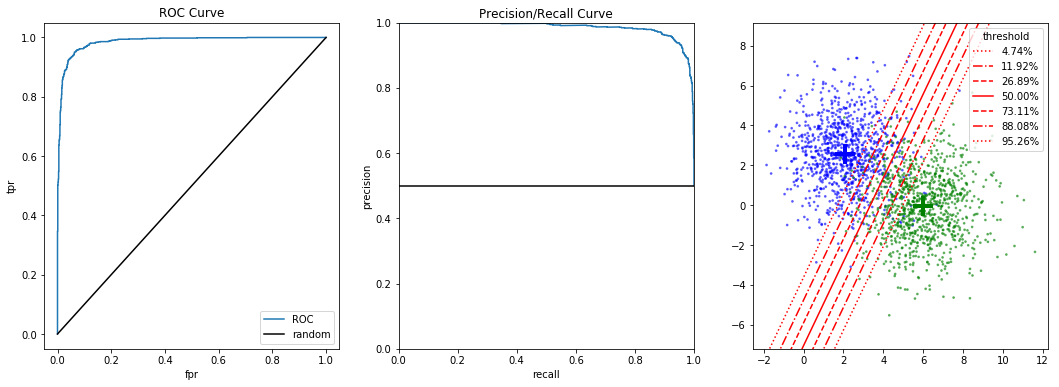

In [22]:
fig, (ax0, ax1, ax3) = plt.subplots(1,3, figsize=(18,6))
df = calculate_threshold_values(model.predict_proba(X)[:,1], y)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)
plot_decision_boundary(X, y, model, ax3)

The "random" black line is a model that guesses the class randomly, parameterized by the probability of guessing one class or another.

There's a probabilistic interpretation of the AUC; Matt Drury discusses it in http://madrury.github.io/jekyll/update/statistics/2017/06/21/auc-proof.html
